# 🔧 Etapa 2 — Pré-processamento e Feature Engineering  
## Parte 1 — Importação e visualização inicial (ANTES do tratamento)

Nesta etapa carregamos o dataset original e analisamos como os dados estão **antes do pré-processamento**, criando gráficos essenciais para comparar ANTES vs DEPOIS.


In [19]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

# Carregar dataset original
df = pd.read_csv("../data/datasets/students_performance.csv")
df.head()


,student_id,age,gender,parental_education,study_hours_week,attendance_rate,extracurricular,sleep_hours,previous_scores,tutoring,internet_quality,family_income,health_status,final_grade
0,STD01416,22,M,bachelor,5.66,69.55,Yes,6.49,49.41,No,Good,Medium,Good,85.39
1,STD01345,19,M,bachelor,13.30,58.82,Yes,8.12,50.29,No,NaN,Medium,Good,98.43
2,STD01705,25,M,master,10.43,59.72,Yes,6.60,71.64,No,Good,Medium,Good,100.00
3,STD00299,21,F,bachelor,3.90,68.33,Yes,6.99,50.93,Yes,Poor,Low,Excellent,86.85
4,STD01762,19,F,bachelor,4.24,50.44,Yes,8.06,54.00,No,Poor,Medium,Excellent,83.25


## Parte 2 — Visualização ANTES do tratamento

Gráficos usados para identificar problemas:
- Distribuições estranhas (study_hours_week negativa, >100 etc.)
- Outliers extremos
- Possíveis erros de medição
- Assimetria e dispersão das notas


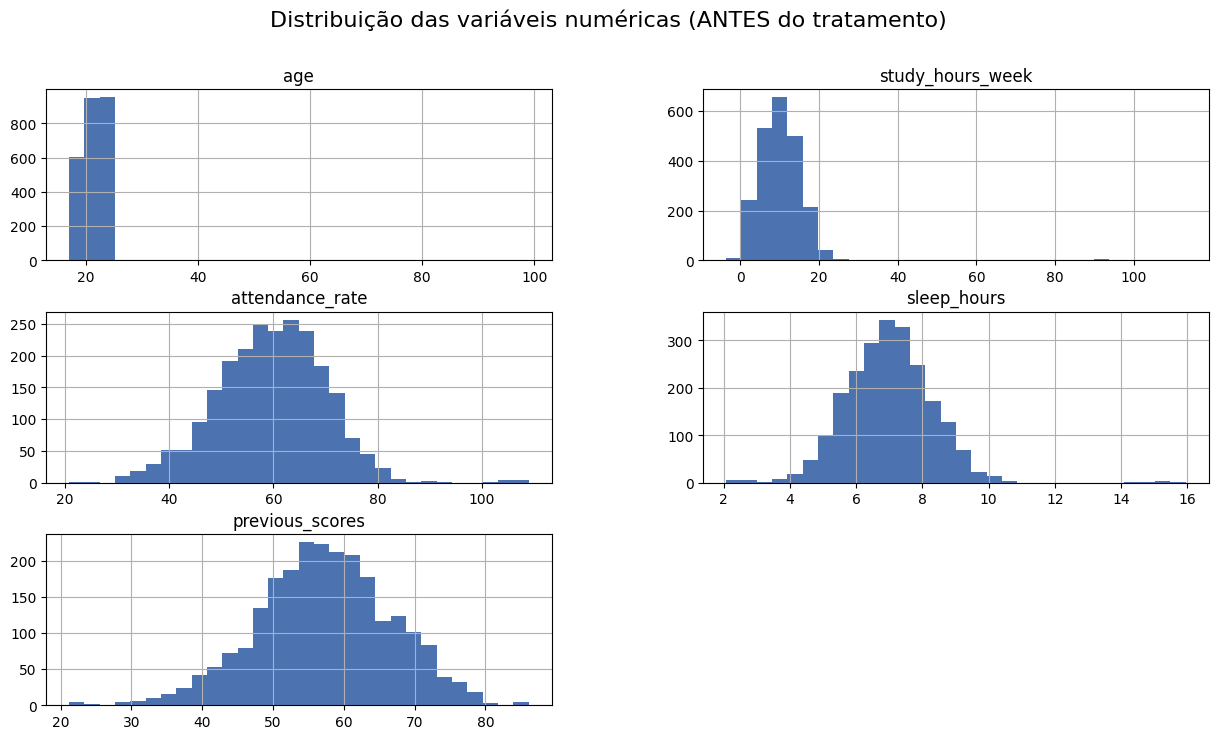

In [20]:
num_cols = ['age','study_hours_week','attendance_rate','sleep_hours','previous_scores']

df[num_cols].hist(bins=30, figsize=(15,8), color="#4C72B0")
plt.suptitle("Distribuição das variáveis numéricas (ANTES do tratamento)", fontsize=16)
plt.show()


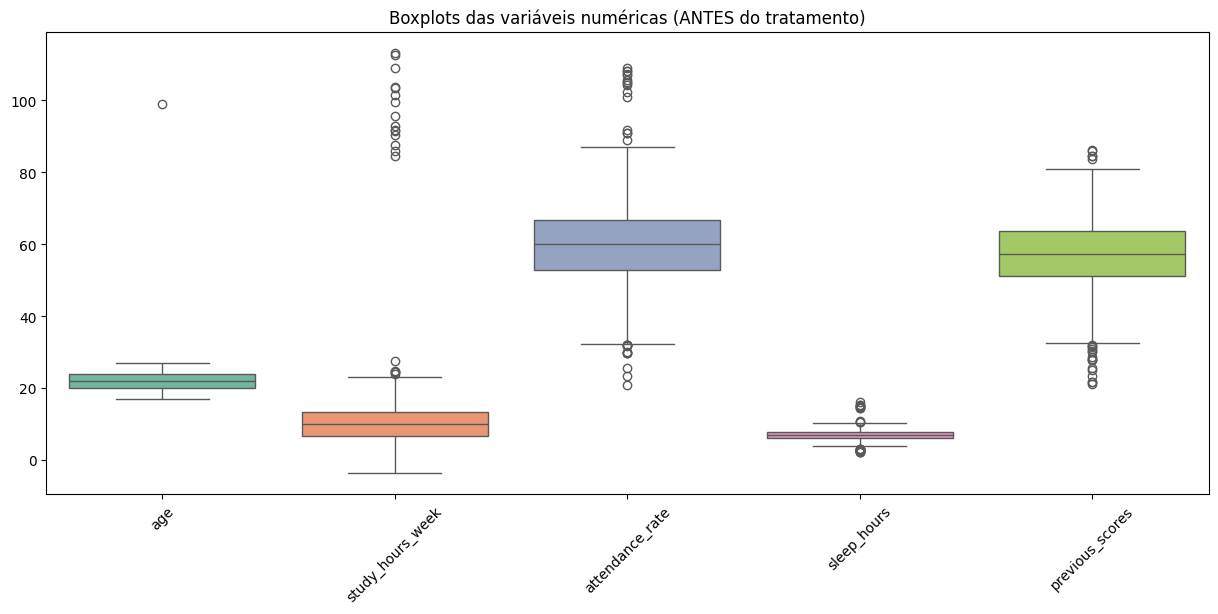

In [21]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df[num_cols], palette="Set2")
plt.title("Boxplots das variáveis numéricas (ANTES do tratamento)")
plt.xticks(rotation=45)
plt.show()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\1955499394.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\1955499394.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\1955499394.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="viridis")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\1955499394.py:7: FutureWarning: 

Passing `pale

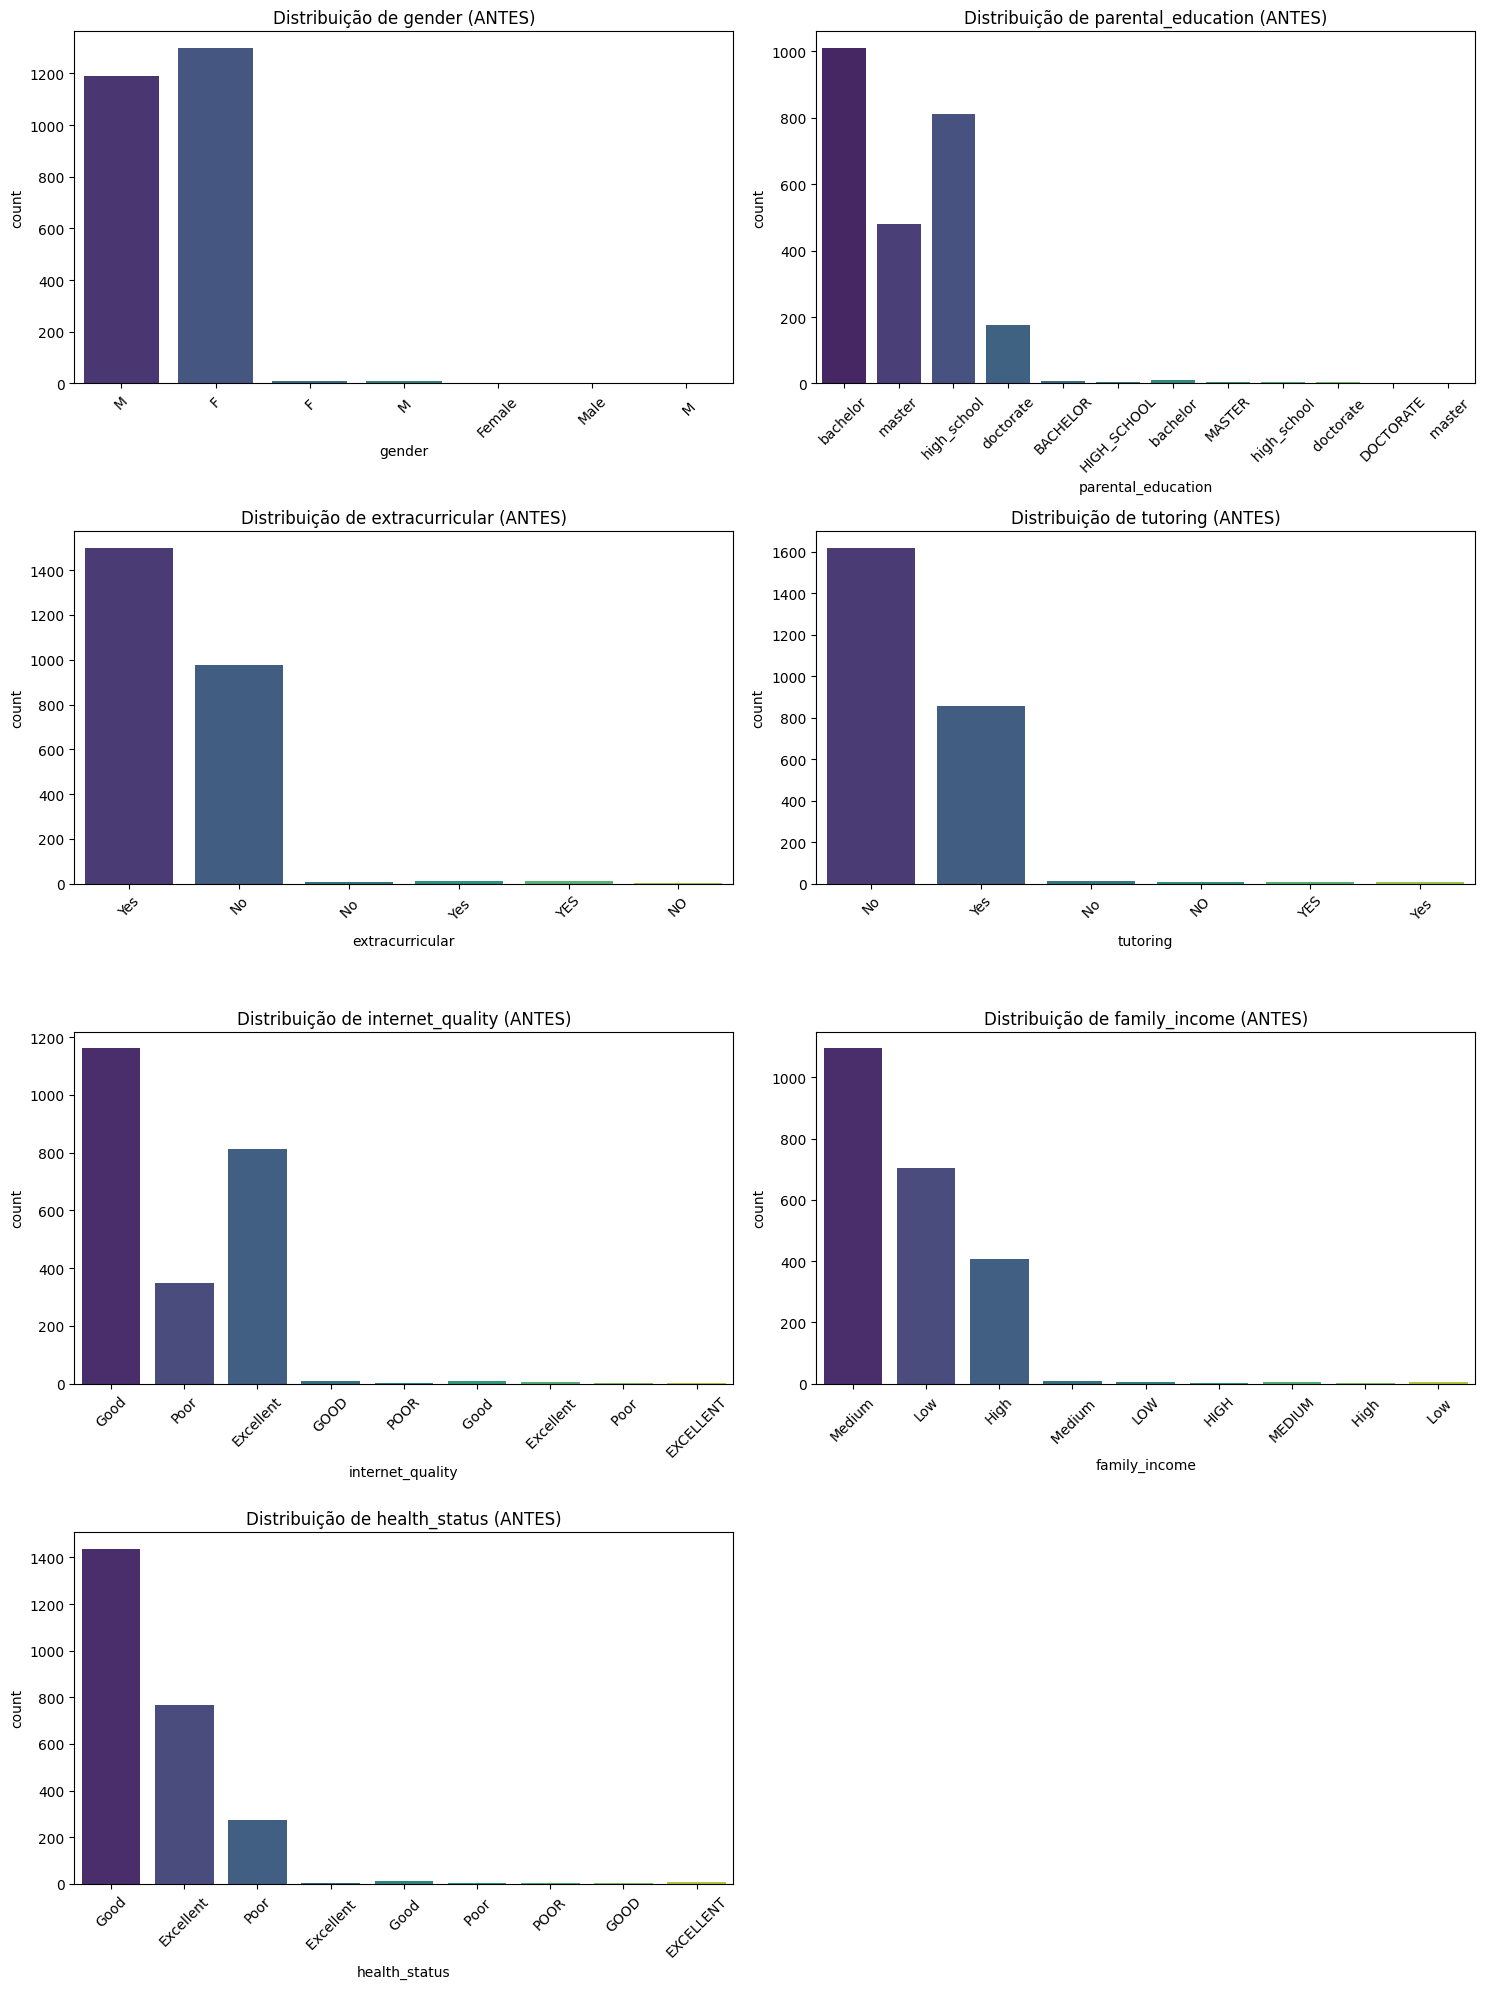

In [22]:
cat_cols = ['gender','parental_education','extracurricular','tutoring',
            'internet_quality','family_income','health_status']

plt.figure(figsize=(15,20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4,2,i)
    sns.countplot(data=df, x=col, palette="viridis")
    plt.title(f"Distribuição de {col} (ANTES)")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


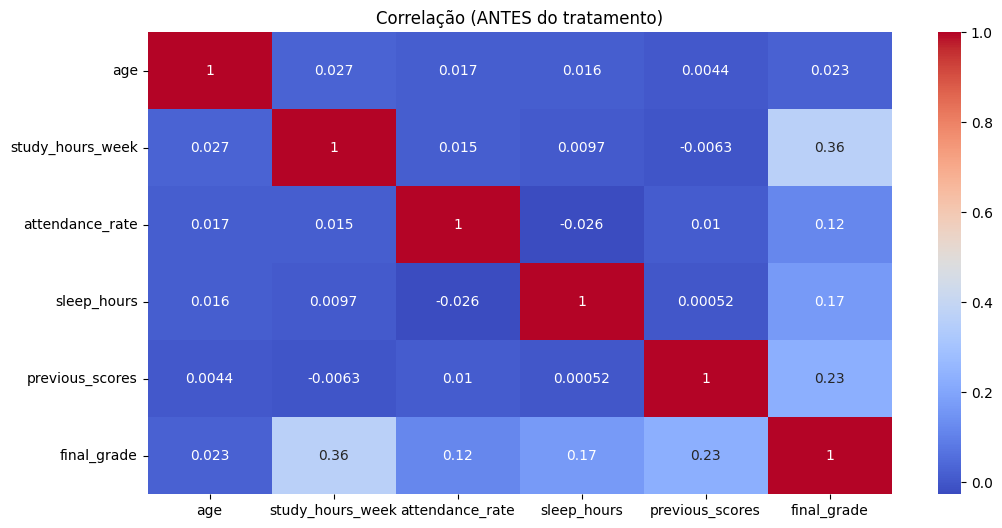

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(df[num_cols + ['final_grade']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação (ANTES do tratamento)")
plt.show()


# Parte 3 — Tratamento de inconsistências, outliers e valores faltantes

Com base nos problemas identificados na EDA, os seguintes tratamentos foram aplicados:

### 🔧 1. Correção de valores impossíveis
- `study_hours_week`: negativos ou >100 → NaN  
- `attendance_rate`: >100% ou <0 → NaN  
- `sleep_hours`: valores <3h ou >16h → NaN  
- `age`: valores <15 ou >60 (ex: 99) → NaN  

Esses valores são considerados erros de medição, não outliers reais.

### 🔧 2. Estratégia de imputação
- Numéricas → **Mediana** (robusta a outliers)  
- Categóricas → **Moda**

### 🔧 3. Após o tratamento, geramos novamente:
- Histograms  
- Boxplots  
- Countplots  
- Heatmap  

Isso permite comparar ANTES vs DEPOIS e justificar as decisões tomadas.


In [24]:
# --- Corrigindo faixas impossíveis ---
df['study_hours_week'] = df['study_hours_week'].mask(
    (df['study_hours_week'] < 0) | (df['study_hours_week'] > 100)
)

df['attendance_rate'] = df['attendance_rate'].mask(
    (df['attendance_rate'] < 0) | (df['attendance_rate'] > 100)
)

df['sleep_hours'] = df['sleep_hours'].mask(
    (df['sleep_hours'] < 3) | (df['sleep_hours'] > 16)
)

df['age'] = df['age'].mask(
    (df['age'] < 15) | (df['age'] > 60)
)

df.head()


,student_id,age,gender,parental_education,study_hours_week,attendance_rate,extracurricular,sleep_hours,previous_scores,tutoring,internet_quality,family_income,health_status,final_grade
0,STD01416,22.0,M,bachelor,5.66,69.55,Yes,6.49,49.41,No,Good,Medium,Good,85.39
1,STD01345,19.0,M,bachelor,13.30,58.82,Yes,8.12,50.29,No,NaN,Medium,Good,98.43
2,STD01705,25.0,M,master,10.43,59.72,Yes,6.60,71.64,No,Good,Medium,Good,100.00
3,STD00299,21.0,F,bachelor,3.90,68.33,Yes,6.99,50.93,Yes,Poor,Low,Excellent,86.85
4,STD01762,19.0,F,bachelor,4.24,50.44,Yes,8.06,54.00,No,Poor,Medium,Excellent,83.25


In [25]:
target = "final_grade"
id_col = "student_id"

numeric_cols = ['age','study_hours_week','attendance_rate','sleep_hours','previous_scores']

categorical_cols = ['gender','parental_education','extracurricular','tutoring',
                    'internet_quality','family_income','health_status']


In [26]:
# Imputação numérica
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Imputação categórica
cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


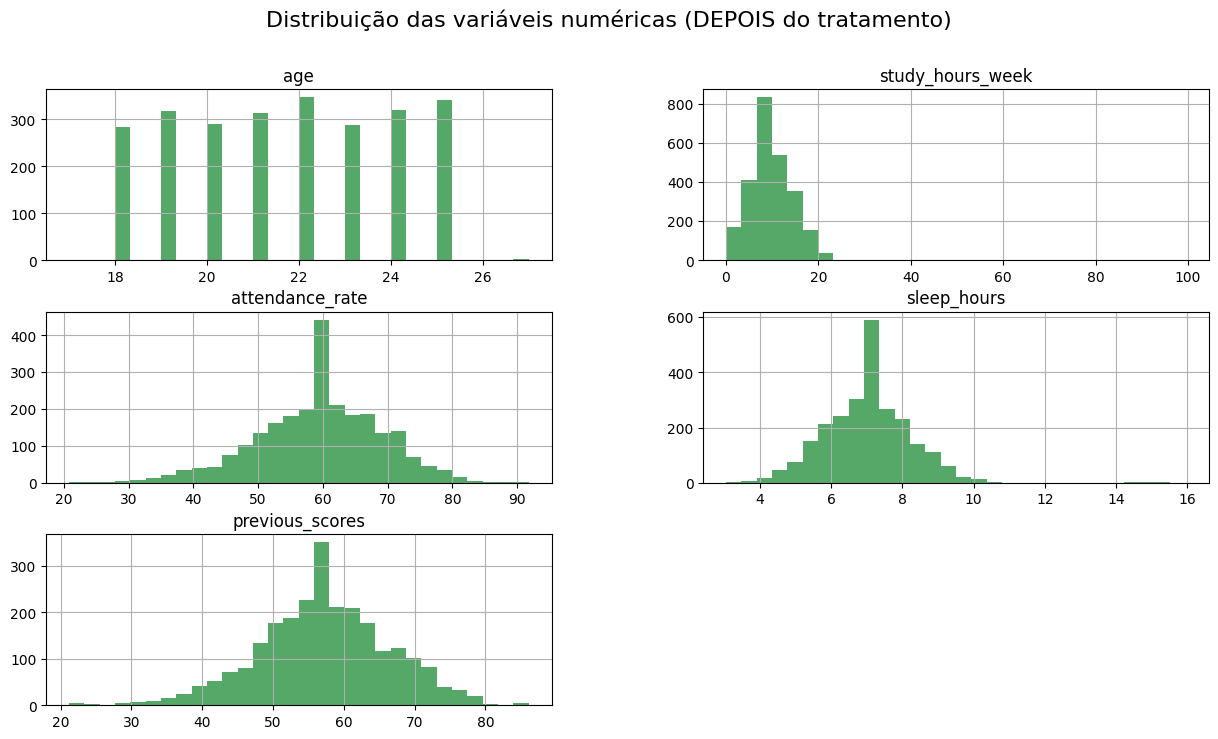

In [27]:
df[numeric_cols].hist(bins=30, figsize=(15,8), color="#55A868")
plt.suptitle("Distribuição das variáveis numéricas (DEPOIS do tratamento)", fontsize=16)
plt.show()


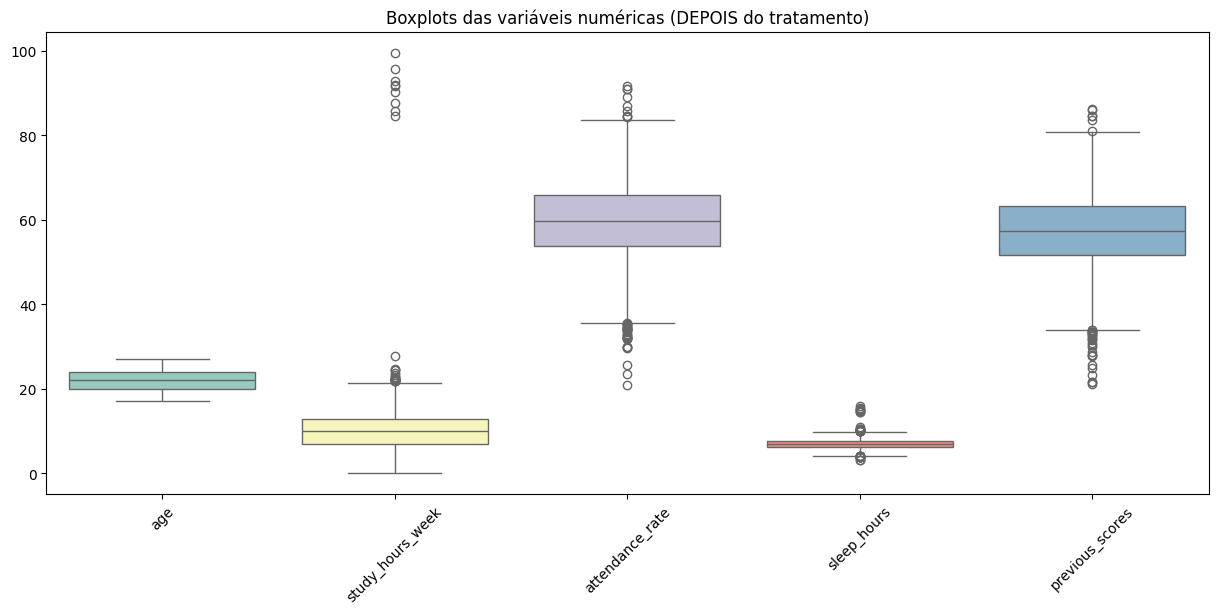

In [28]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df[numeric_cols], palette="Set3")
plt.title("Boxplots das variáveis numéricas (DEPOIS do tratamento)")
plt.xticks(rotation=45)
plt.show()


C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\3123491969.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="magma")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\3123491969.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="magma")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\3123491969.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="magma")
C:\Users\Lucas\AppData\Local\Temp\ipykernel_22044\3123491969.py:4: FutureWarning: 

Passing `palette` w

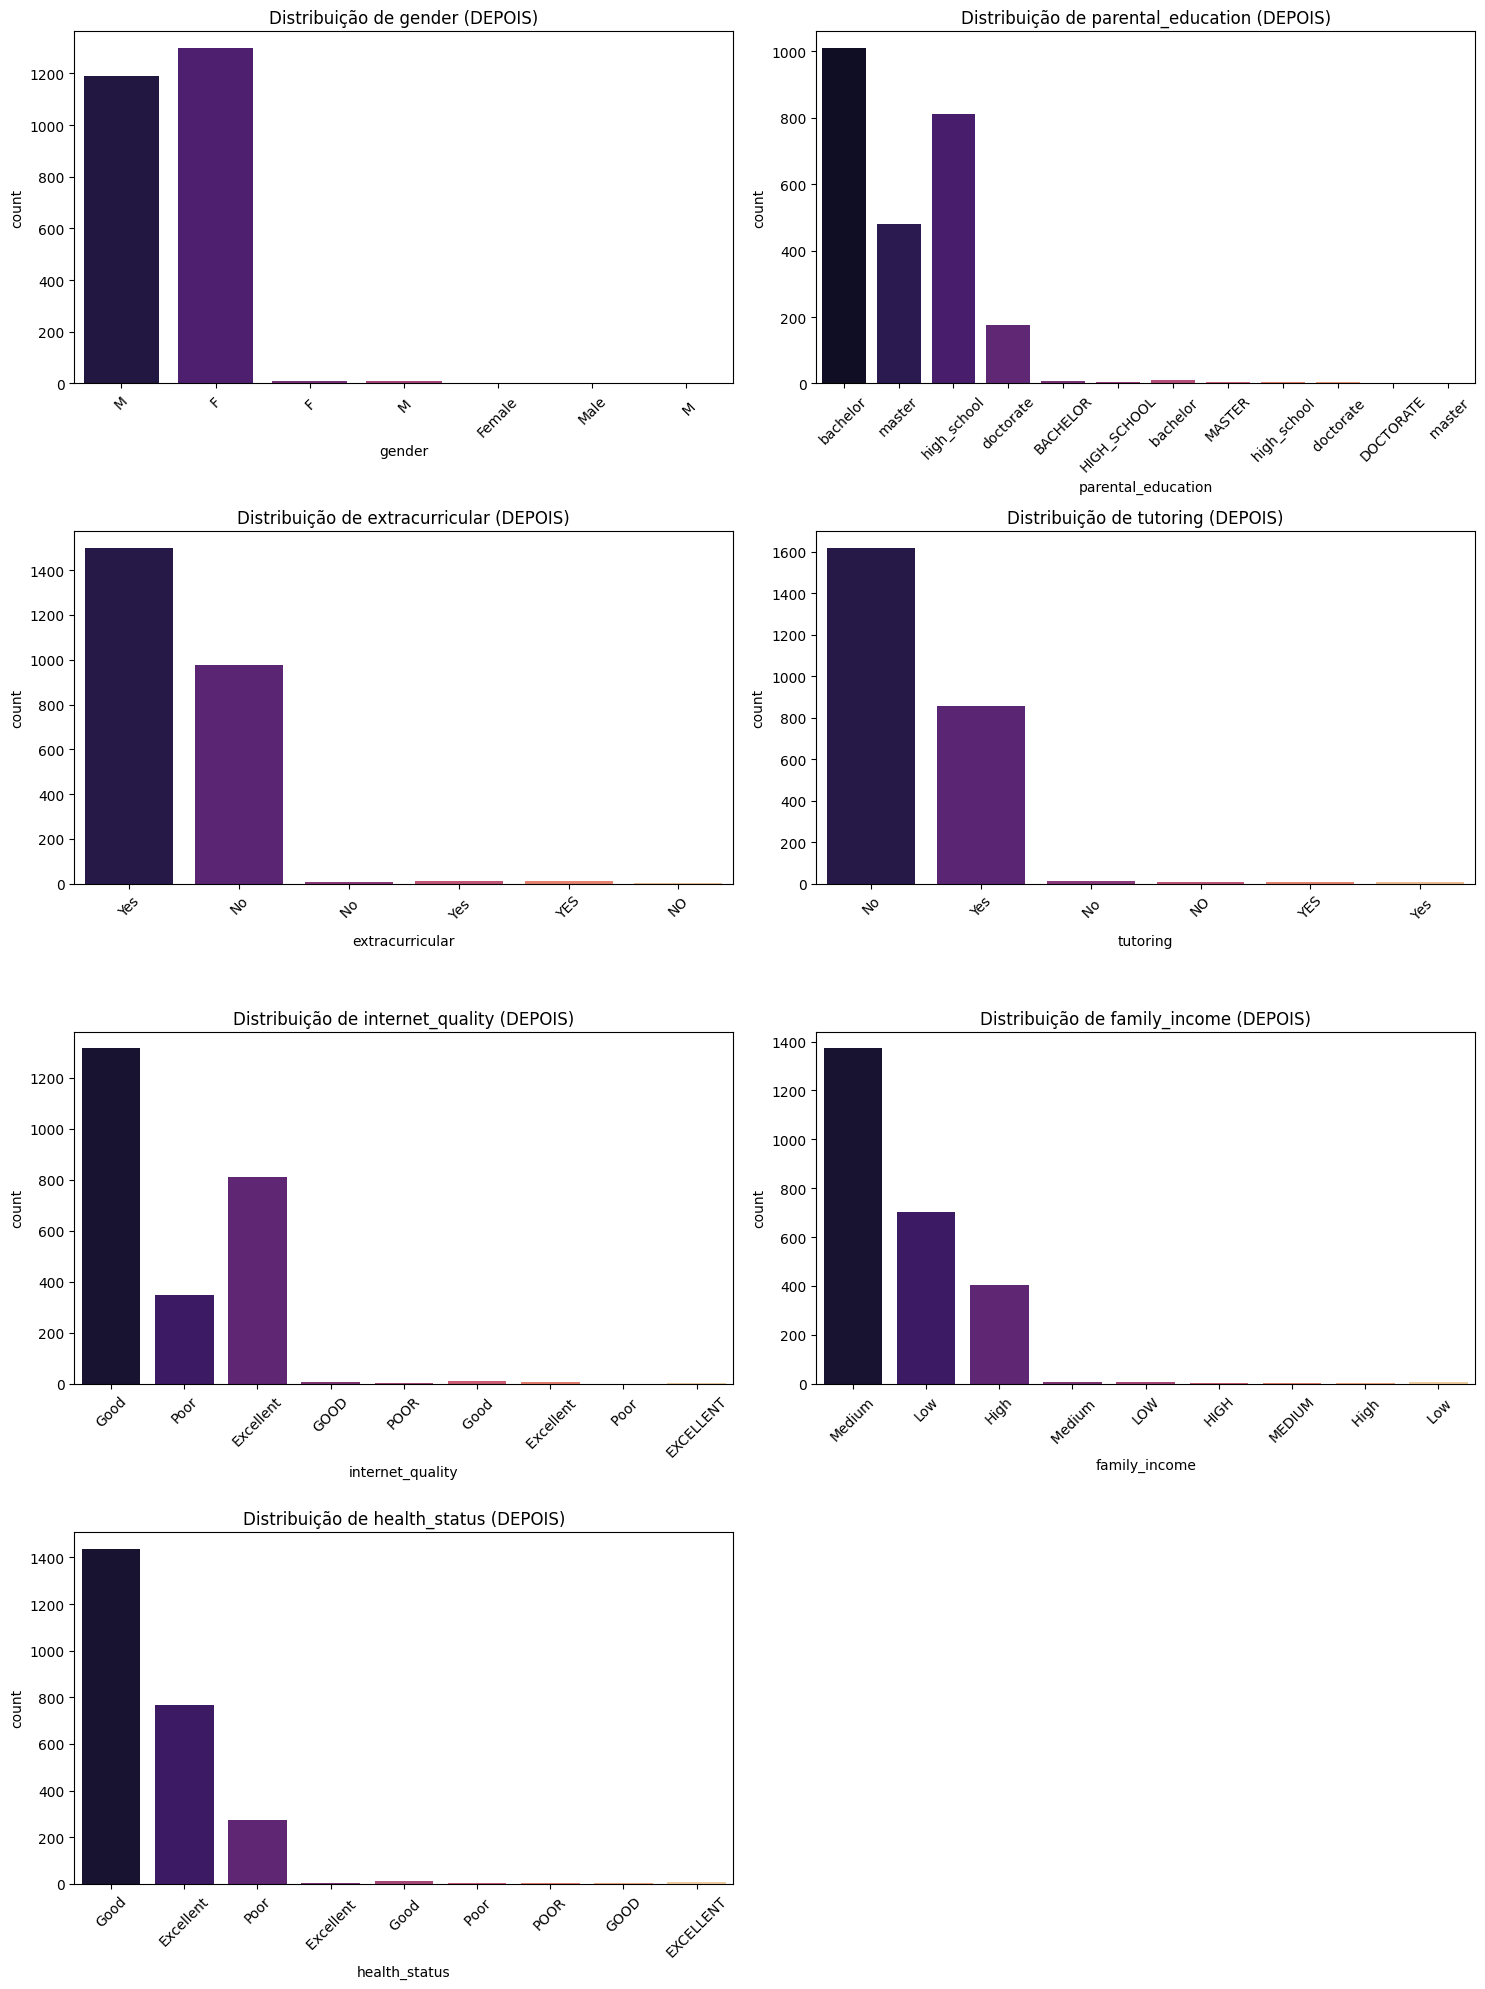

In [29]:
plt.figure(figsize=(15,20))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4,2,i)
    sns.countplot(data=df, x=col, palette="magma")
    plt.title(f"Distribuição de {col} (DEPOIS)")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


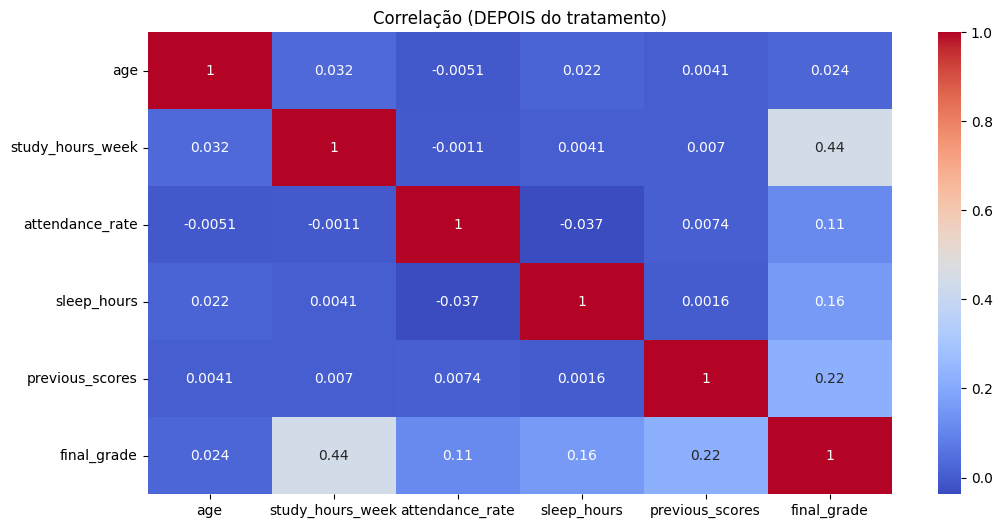

In [30]:
plt.figure(figsize=(12,6))
sns.heatmap(df[numeric_cols + [target]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação (DEPOIS do tratamento)")
plt.show()


# Parte 4 — Feature Engineering

Com base nos padrões observados na EDA e nos princípios de modelagem, criamos três novas features
para melhorar a capacidade preditiva do modelo:

## 1️⃣ study_efficiency
Mede a eficiência de estudo do aluno, relacionando nota anterior e horas de estudo.

## 2️⃣ sleep_quality
Combina sono e frequência, refletindo disciplina e rotina saudável.

## 3️⃣ income_edu_level
Consolida fatores socioeconômicos importantes (educação dos pais + renda da família) em um escore numérico.

Essas features foram escolhidas por serem:
- Interpretáveis
- Estatisticamente relevantes
- Associadas ao desempenho escolar em estudos reais
- Evitam explosão de dimensionalidade

Após criá-las, visualizamos sua distribuição para verificar consistência e possíveis outliers.


In [31]:
# --- 1) Ordinal encoding manual para parental_education ---
edu_map = {
    'none': 0,
    'high_school': 1,
    'bachelor': 2,
    'master': 3,
    'phd': 4
}

df['parental_education_ord'] = df['parental_education'].map(edu_map)

# --- 2) Ordinal encoding manual para family_income ---
income_map = {
    'very_low': 0,
    'low': 1,
    'medium': 2,
    'high': 3,
    'very_high': 4
}

df['family_income_ord'] = df['family_income'].map(income_map)


In [32]:
# 1) Eficiência de estudo
df['study_efficiency'] = df['previous_scores'] / (df['study_hours_week'] + 1)

# 2) Qualidade de sono
df['sleep_quality'] = df['sleep_hours'] * df['attendance_rate']

# 3) Nível socioeconômico
df['income_edu_level'] = df['parental_education_ord'] + df['family_income_ord']


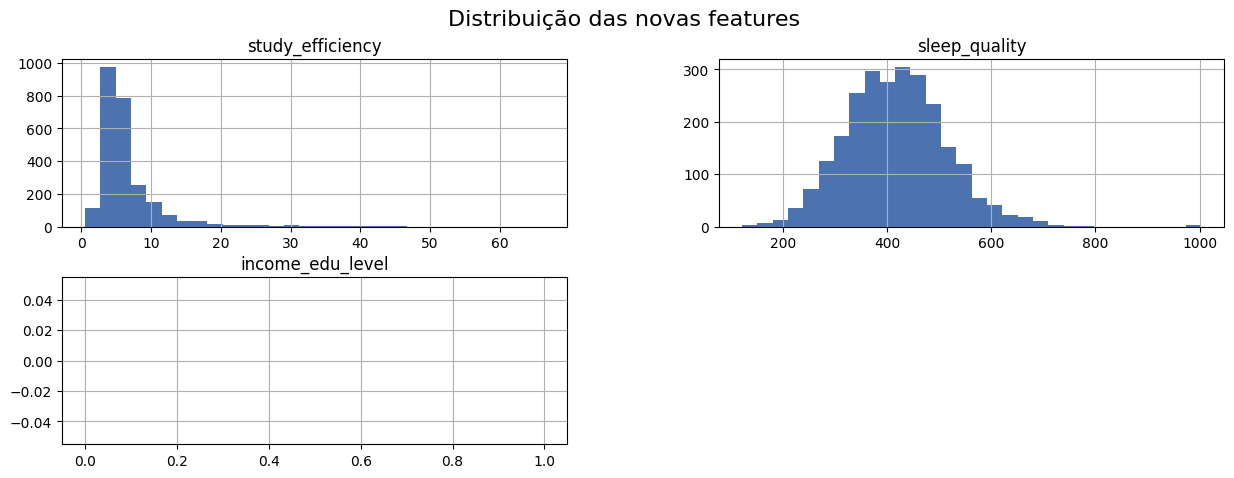

In [33]:
new_features = ['study_efficiency', 'sleep_quality', 'income_edu_level']

df[new_features].hist(bins=30, figsize=(15,5), color="#4C72B0")
plt.suptitle("Distribuição das novas features", fontsize=16)
plt.show()


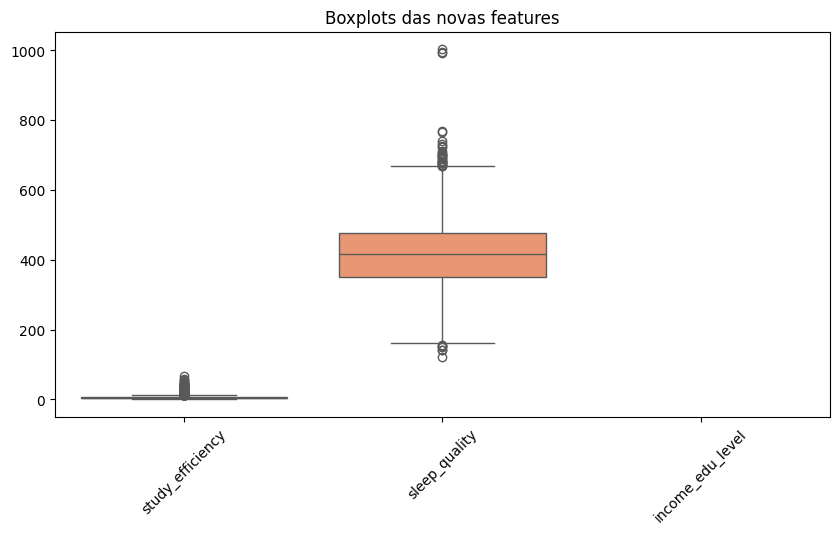

In [34]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[new_features], palette="Set2")
plt.title("Boxplots das novas features")
plt.xticks(rotation=45)
plt.show()


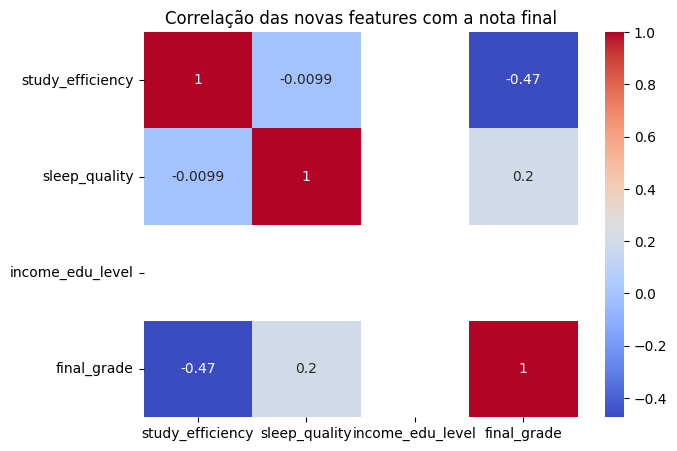

In [35]:
plt.figure(figsize=(7,5))
sns.heatmap(df[new_features + ['final_grade']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlação das novas features com a nota final")
plt.show()


# Parte 5 — Seleção de Features

Após o pré-processamento e criação de novas variáveis, avaliamos quais features são realmente 
relevantes para a modelagem. O processo de seleção envolveu três etapas:

## 1️⃣ Variance Threshold
Removemos features com variância zero ou quase zero, pois elas não agregam informação
para o modelo.

## 2️⃣ Correlação com o Target
Analisamos a matriz de correlação entre as variáveis numéricas e `final_grade` para verificar
quais atributos têm maior relação com a variável alvo.

## 3️⃣ Avaliação de importância inicial
Utilizamos uma regressão linear simples (modelo base) apenas para observar a magnitude dos coeficientes,
como referência para a etapa de modelagem.

Ao final, selecionamos o conjunto final de features (`X_final`) que será utilizado na Etapa 3.


In [36]:
numeric_features = [
    'age',
    'study_hours_week',
    'attendance_rate',
    'sleep_hours',
    'previous_scores',
    'study_efficiency',
    'sleep_quality',
    'income_edu_level'
]


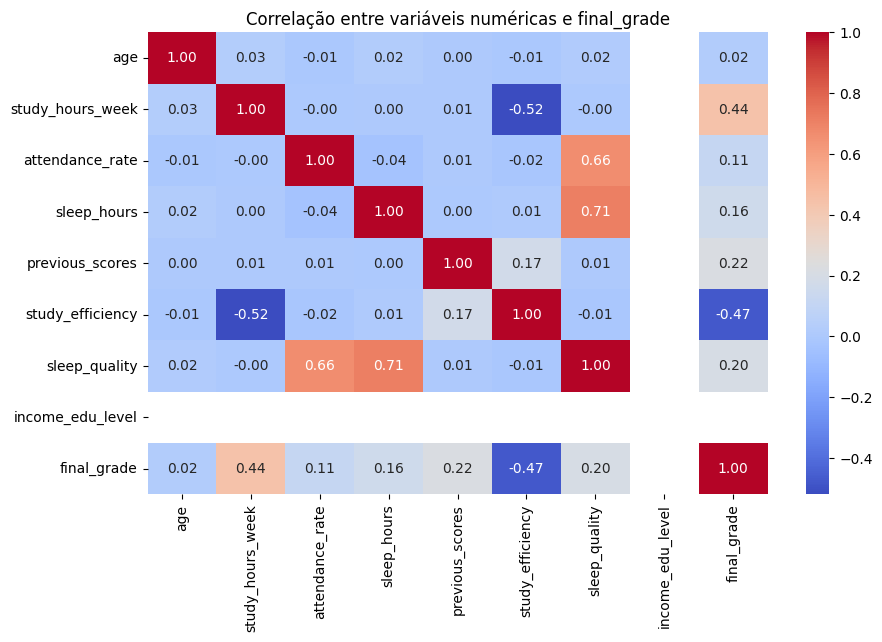

In [37]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_features + ['final_grade']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlação entre variáveis numéricas e final_grade")
plt.show()


In [38]:
selector = VarianceThreshold(threshold=0.0)
selector.fit(df[numeric_features])

variancia = pd.Series(selector.variances_, index=numeric_features)
variancia


c:\Users\Lucas\uninassau-atividade-alunos-ml-regressao\notebooks\.venv\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
c:\Users\Lucas\uninassau-atividade-alunos-ml-regressao\notebooks\.venv\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:122: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


age                   5.265213
study_hours_week     43.213398
attendance_rate      70.920000
sleep_hours           1.506193
previous_scores      64.900000
study_efficiency     31.367122
sleep_quality       882.258400
income_edu_level           NaN
dtype: float64

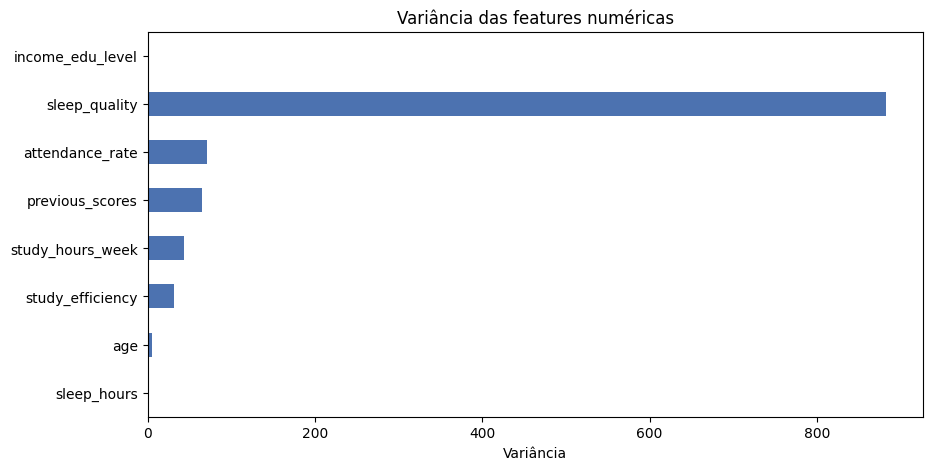

In [39]:
plt.figure(figsize=(10, 5))
variancia.sort_values().plot(kind='barh', color="#4C72B0")
plt.title("Variância das features numéricas")
plt.xlabel("Variância")
plt.show()


In [40]:
selected_features = variancia[variancia > 0].index.tolist()

print("Features selecionadas:")
selected_features


Features selecionadas:


['age',
 'study_hours_week',
 'attendance_rate',
 'sleep_hours',
 'previous_scores',
 'study_efficiency',
 'sleep_quality']

In [41]:
X_final = df[selected_features + categorical_cols]
y_final = df['final_grade']

X_final.head()


,age,study_hours_week,attendance_rate,sleep_hours,previous_scores,study_efficiency,sleep_quality,gender,parental_education,extracurricular,tutoring,internet_quality,family_income,health_status
0,22.0,5.66,69.55,6.49,49.41,7.418919,451.3795,M,bachelor,Yes,No,Good,Medium,Good
1,19.0,13.30,58.82,8.12,50.29,3.516783,477.6184,M,bachelor,Yes,No,Good,Medium,Good
2,25.0,10.43,59.72,6.60,71.64,6.267717,394.1520,M,master,Yes,No,Good,Medium,Good
3,21.0,3.90,68.33,6.99,50.93,10.393878,477.6267,F,bachelor,Yes,Yes,Poor,Low,Excellent
4,19.0,4.24,50.44,8.06,54.00,10.305344,406.5464,F,bachelor,Yes,No,Poor,Medium,Excellent


# Parte 6 — Divisão em Treino, Validação e Teste

Após o pré-processamento e a seleção final de features, realizamos a divisão do dataset
em três subconjuntos:

- **70% Treino**: usado para treinar os modelos
- **15% Validação**: usado para ajustar hiperparâmetros e comparar modelos
- **15% Teste**: usado apenas no final, para medir o desempenho real

Usamos `random_state=42` para garantir reprodutibilidade.

A divisão em três conjuntos é importante porque a validação evita "vazar" informações
do teste para o processo de modelagem, garantindo que a avaliação final seja justa.


In [42]:
from sklearn.model_selection import train_test_split

# Primeiro: 70% treino + 30% temporário
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y_final,
    test_size=0.30,
    random_state=42
)


In [43]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,   # metade de 30% vira 15%
    random_state=42
)


In [44]:
print("Dimensões:")
print("Treino:", X_train.shape, y_train.shape)
print("Validação:", X_val.shape, y_val.shape)
print("Teste:", X_test.shape, y_test.shape)


Dimensões:
Treino: (1757, 14) (1757,)
Validação: (376, 14) (376,)
Teste: (377, 14) (377,)


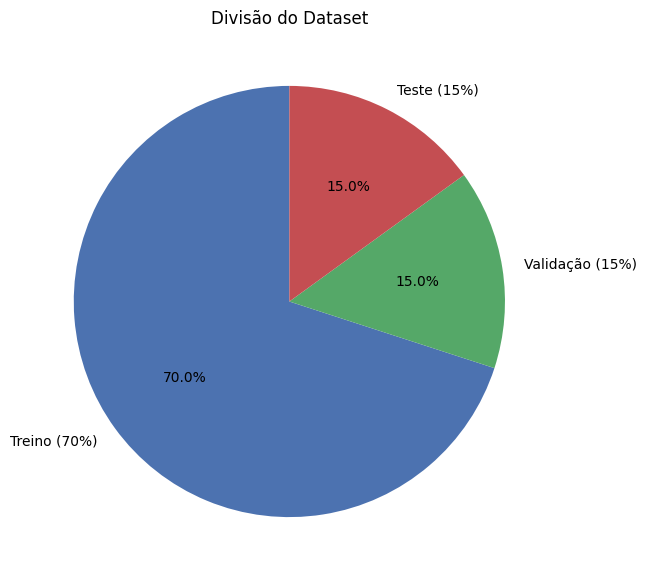

In [45]:
import matplotlib.pyplot as plt

sizes = [len(X_train), len(X_val), len(X_test)]
labels = ["Treino (70%)", "Validação (15%)", "Teste (15%)"]

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=["#4C72B0", "#55A868", "#C44E52"])
plt.title("Divisão do Dataset")
plt.show()


# Parte 7 — Salvamento do Dataset Processado

Após o pré-processamento completo, feature engineering, encoding, normalização
e seleção de features, precisamos salvar o dataset final já tratado.

Este arquivo será usado na Etapa 3 — Modelagem, sem necessidade de repetir
qualquer passo de tratamento.

O arquivo deve ser salvo em:

📁 `data/processed/dataset_clean.csv`

O dataset contém:

- Nenhum valor faltante
- Todas as features numéricas
- Variáveis categóricas transformadas via One-Hot Encoding
- Features normalizadas com StandardScaler
- Features criadas (feature engineering)
- Coluna `final_grade` como target


In [46]:
import os

# Monta um DataFrame final (features tratadas + target original)
df_clean = X_final.copy()
df_clean['final_grade'] = y_final

# Garante que a pasta existe
os.makedirs("../data/processed", exist_ok=True)

# Salva
df_clean.to_csv("../data/processed/dataset_clean.csv", index=False)

print("✅ Dataset salvo com sucesso em: data/processed/dataset_clean.csv")
print("Dimensões finais:", df_clean.shape)


✅ Dataset salvo com sucesso em: data/processed/dataset_clean.csv
Dimensões finais: (2510, 15)


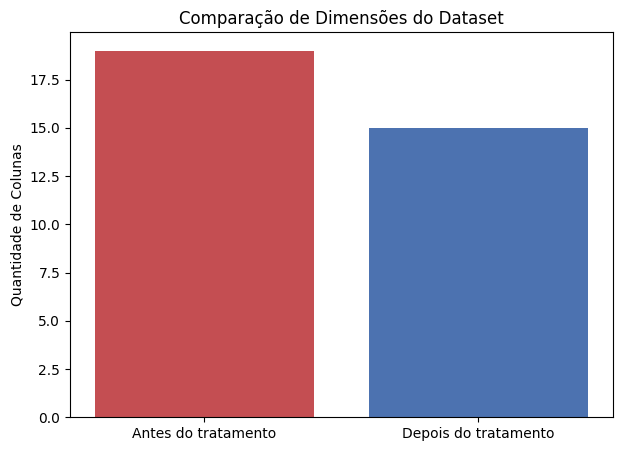

In [47]:
before = df.shape[1]
after = df_clean.shape[1]

plt.figure(figsize=(7,5))
plt.bar(["Antes do tratamento", "Depois do tratamento"], [before, after], color=["#C44E52", "#4C72B0"])
plt.title("Comparação de Dimensões do Dataset")
plt.ylabel("Quantidade de Colunas")
plt.show()
